<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/03_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature engineering

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [29]:
df = pd.read_parquet('/Users/philipp.lampert/repositories/mymandible/data/preprocessing/02_preprocessed.parquet')

As a first step we will remove all columns that contain data only meant for descriptive purposes but that are not useful as predictors. In addition, these variables are conditional, meaning they are not applicable to all rows which leads to a lot of missing data inside these columns that cannot be imputed.

In [30]:
remove_columns = ['which_autoimmune_disease', 
                  'which_bleeding_disorder', 
                  'long_plate_thickness', 
                  'mini_plate_thickness', 
                  'tmj_replacement_type',
                 'venous_anastomosis_type___end_end',
                 'venous_anastomosis_type___end_side']
df = df.drop(columns=remove_columns)

We first create a list of all predictor variables, as we will only remove variables that are predictors.

In [31]:
first_outcome_var = df.columns.get_loc('days_to_follow_up')
predictors = df.columns[:first_outcome_var].tolist()
outcomes = df.columns[first_outcome_var:].tolist()

We will now remove all boolean variables that have a prevalence of less than 5% of either level as low-prevalence variables can lead to overfitting.

In [32]:
bool_predictors = df[predictors].select_dtypes('boolean').columns.values
prevalence = df[bool_predictors].mean(numeric_only=True)
low_prevalence_columns = prevalence[prevalence < 0.05].index.tolist()
low_prevalence_columns

['comorbidity___osteoporosis',
 'comorbidity___thrombosis',
 'comorbidity___bleeding_disorder']

We will now check if these patients had any other comorbidity. If yes, we can simply delete the two variables in question, if not, we will assign these patients to `comorbidity___none`.

In [33]:
comorbidity_columns = [col for col in df.columns if col.startswith("comorbidity___")]
other_comorbidity_columns = [x for x in comorbidity_columns if x not in low_prevalence_columns]

lpc_mask = df[low_prevalence_columns].any(axis=1)
occ_mask = df[other_comorbidity_columns].any(axis=1)
df.loc[lpc_mask & ~occ_mask, 'comorbidity___none'] = True

for col in low_prevalence_columns:
    predictors.remove(col)

Let's now do the same for very high prevalence columns > 95%.

In [34]:
high_prevalence_columns = prevalence[prevalence > 0.95].index.tolist()
high_prevalence_columns

['urkens_classification___b']

In [35]:
predictors.remove('urkens_classification___b')

Next, we will examine the categorical variables and check which have levels with a prevalence of less than 5%.

In [36]:
categorical_columns = df[predictors].select_dtypes('category').columns.tolist()
low_prevalence_levels =[]

for column in categorical_columns:
    level_percentages = df[column].value_counts(normalize=True)
    if any(level_percentages < 0.05):
        low_prevalence_levels.append(column)

low_prevalence_levels

['indication', 'flap_donor_site', 'flap_segment_count']

In [37]:
df['indication'].value_counts(normalize=True)

indication
malignant_tumor                     0.692958
osteoradionecrosis                  0.129577
flap_loss                           0.039437
benign_tumor                        0.033803
osteomyelitis                       0.033803
secondary_reconstruction            0.033803
medication_related_osteonecrosis    0.030986
trauma                              0.005634
Name: proportion, dtype: float64

We remove levels that are unrelated and with a prevalence of < 5%.

In [38]:
levels_to_remove = ['osteomyelitis', 'medication_related_osteonecrosis', 'benign_tumor', 'trauma']
df = df[~df['indication'].isin(levels_to_remove)]

Levels that are related are being grouped together.

In [39]:
secondary_reconstruction = ['secondary_reconstruction', 'flap_loss']

conditions = [df['indication'].isin(secondary_reconstruction)]

df['indication'] = np.select(conditions, ['secondary_reconstruction'], default=df['indication'])
df['indication'] = df['indication'].astype('category')
df['indication'].value_counts(normalize=True)

indication
malignant_tumor             0.773585
osteoradionecrosis          0.144654
secondary_reconstruction    0.081761
Name: proportion, dtype: float64

This way we replaced the very low prevalence columns with groups.

In [40]:
df['flap_donor_site'].value_counts(normalize=True)

flap_donor_site
fibula     0.871069
scapula    0.094340
pelvis     0.034591
Name: proportion, dtype: float64

In [41]:
df = df[df['flap_donor_site'] != 'pelvis']
df['flap_donor_site'] = df['flap_donor_site'].cat.remove_unused_categories()

In [42]:
df['flap_segment_count'].value_counts(normalize=True)

flap_segment_count
two      0.530945
three    0.302932
one      0.159609
four     0.006515
Name: proportion, dtype: float64

In [43]:
df = df[df['flap_segment_count'] != 'four']
df['flap_segment_count'] = df['flap_segment_count'].cat.remove_unused_categories()

Let's now check if ther are any high prevalence levels within categorical columns > 95%.

In [44]:
categorical_columns = df[predictors].select_dtypes('category').columns.tolist()
high_prevalence_levels =[]

for column in categorical_columns:
    level_percentages = df[column].value_counts(normalize=True)
    if any(level_percentages > 0.95):
        high_prevalence_levels.append(column)

high_prevalence_levels

[]

There are no categorical levels with a prevalence > 95%.

## Encoding

We now have to encode all remaining categorical variables to numeric/binary variables as most models can handle categorical data and handle collinearity.

In [45]:
label_mapping = {'one': 1, 'two': 2, 'three': 3}
df['flap_segment_count'] = df['flap_segment_count'].map(label_mapping).astype('UInt8')

In [46]:
collinear_cols = ['weight_kg', 'height_cm', 'venous_anastomosis_tool___coupler', 'venous_anastomosis_tool___suture']

for x in collinear_cols:
    predictors.remove(x)

In [47]:
df_outcomes = df[outcomes]
col_to_encode = df[predictors].select_dtypes(exclude=[np.number, bool]).columns.tolist()
col_to_encode

['indication', 'prior_flap', 'flap_donor_site', 'plate_type']

### All levels dataframe

In [48]:
df_encoded_all_levels = pd.get_dummies(df[predictors], columns=col_to_encode, prefix_sep='___', drop_first=False, dtype=bool)
bool_cols = df_encoded_all_levels.select_dtypes('bool').columns.tolist()
df_encoded_all_levels[bool_cols] = df_encoded_all_levels[bool_cols].astype('boolean')

In [49]:
df_encoded_all_levels = pd.merge(df_encoded_all_levels, df_outcomes, left_index=True, right_index=True)

### Dropped first level dataframe

In [50]:
df_encoded_dropped_first = pd.get_dummies(df[predictors], columns=col_to_encode, prefix_sep='___', drop_first=False, dtype=bool)
bool_cols = df_encoded_dropped_first.select_dtypes('bool').columns.tolist()
df_encoded_dropped_first[bool_cols] = df_encoded_dropped_first[bool_cols].astype('boolean')

In [51]:
first_level = df_encoded_dropped_first.filter(like='none').columns.tolist()
first_level.extend(['indication___malignant_tumor', 'flap_donor_site___fibula', 'plate_type___cad_long'])
df_encoded_dropped_first_pred = df_encoded_dropped_first.drop(first_level, axis=1)

In [52]:
df_encoded_dropped_first = pd.merge(df_encoded_dropped_first_pred, df_outcomes, left_index=True, right_index=True)

## Collinearity

<Axes: >

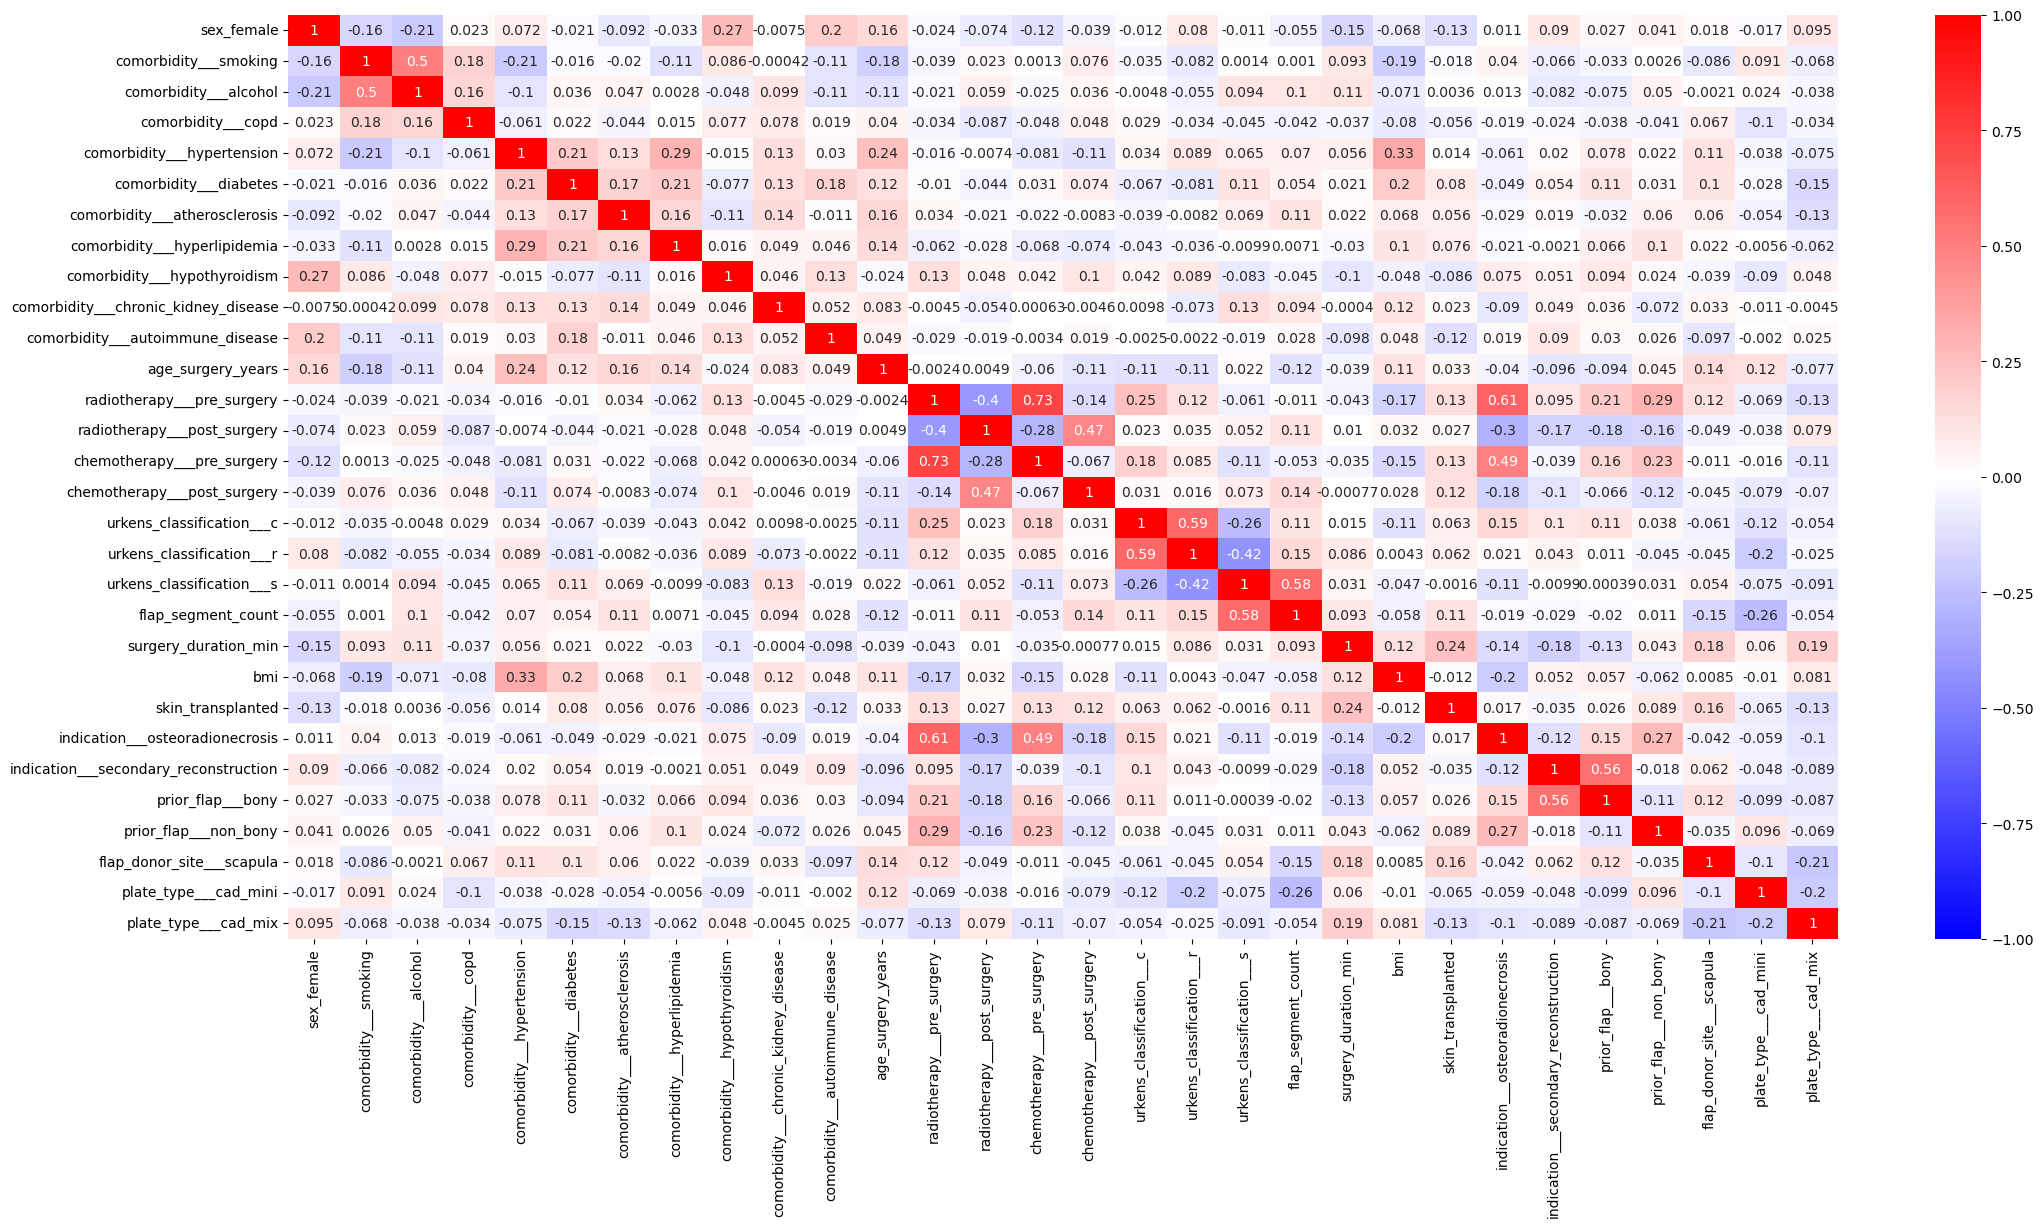

In [53]:
corr = df_encoded_dropped_first_pred.corr(numeric_only=False)
fig, ax = plt.subplots()
fig.set_size_inches(25, 12)
sns.heatmap(corr, annot=True, cmap="bwr", center=0, vmin=-1, vmax=1, ax=ax)

## Exporting data frames
We will now save different data frames each handling categorical data differently. This is because some models can handle categorical data natively without encoding while others require all data to be in a numeric format.

In [54]:
df_encoded_dropped_first.to_parquet('03_encoded_dropped_first.parquet')
df_encoded_all_levels.to_parquet('03_encoded_all_levels.parquet')

!mv 03_encoded_dropped_first.parquet /Users/philipp.lampert/repositories/mymandible/data/preprocessing/
!mv 03_encoded_all_levels.parquet /Users/philipp.lampert/repositories/mymandible/data/preprocessing/